# DAML Q-Learning

Q-Learning is a branch of Reinforcement Learning that uses
a policy to define every state in an environment as closer
or further away from the goal.
Where Reinforcement Learning is a way to teach an agent
(model) based on a reward associated with every action it takes.
Q-Learning uses the reward values to build a model of the entire
world - the policy - the policy then decides the best action
based on rewards available in the entire world rather than just
the next action.

For our purposes the interesting detail of Q-Learning
is that the policy function is learned indirectly.
The labels/targets in the data we can get from the
world/environemnt are not the labels from which
the policy can be trained.

Every reasonably complex model will perform some form of indirect
learning.  The model learns patterns in the data we may not
be aware of.  And then use these unknown to the use patterns
to correctly perform label assignment.  This is assuming that
the model has enough data to contain the pattern consistently
and not overfit to the data.

In Q-Learning we use the fact that the number of states and actions
is finite (even if they're real numbers, there are always value caps).
The finite nature of the world solved by Q-Learning then allows us
to build a model that will predict not only the association between
action and rewards but also future rewards.

We will use a toy text example from `gymnasium` and `torch` for this example,
i.e. you need to install them.

- `pip install 'gymnasium[toy-text]'`
- `pip install torch`

Training a torch model on CPU is very time consuming.
With the number of episodes and steps we take in the example
it should be barely sufferable to do it a CPU
but it will take a while.
We try to use CUDA or MPS if that is available.

In [1]:
import math
import random
from collections import deque, namedtuple

import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
DEVICE

device(type='mps')

Our model will solve the cliff walking game.
It consist of walking around a cliff edge from
an initial position to a goal on the other side.
It is a rather simple game,
the screen is divided into 4 rows of 12 fields.
One starts at the bottom left of the screen
and the goal is at the bottom right of the screen.
All other fields at the bottom of the screen are a cliff edge.
One can move into all four directions but accont exit the screen.
Moving onto the cliff edge makes the player fall of the cliff
and return to the strting position.

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

0. Move up
1. Move right
2. Move down
3. Move left

And the position of the player is encoded as the index of the field
from 0 at the top left, to 47 at the bottom right (goal).

In [3]:
env = gym.make("CliffWalking-v1", render_mode="rgb_array")
observation, info = env.reset()
solution = [0] * 2 + [1] * 12 + [2] * 2
observation, info, env.action_space.n, solution

(36,
 {'prob': 1},
 np.int64(4),
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2])

After using `gymnasium` to generate this simulation environemnt
we start a new game with `.reset()` and build a hand crafted solution.

The solution moves twice up, then all the way to the right
and finally twice down.
Below we plot this human crafted solution.
The plotting code also shows us how we interact with
with the game environment to take steps.

/Users/mike/daml/.venv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


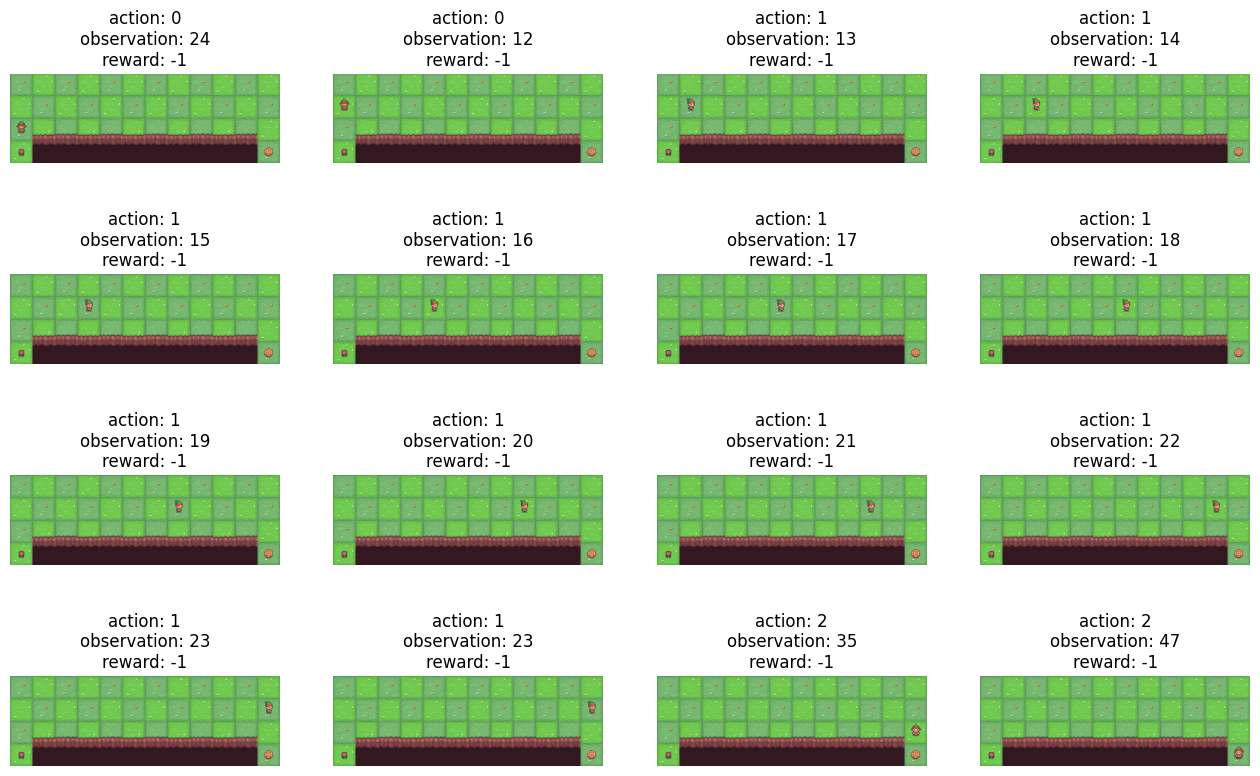

In [4]:
_, ax = plt.subplots(4, 4, figsize=(16, 10))
reward, terminated, truncated, action = 0, False, False, 0
for i, action in enumerate(solution):
    if terminated or truncated:
        break
    observation, reward, terminated, truncated, info = env.step(action)
    ax.flat[i].imshow(env.render())
    ax.flat[i].set_title(
        f"action: {action}\nobservation: {observation}\nreward: {reward}"
    )
    ax.flat[i].axis("off")
env.close()

The game is playable but this is not a dataset to train an ML model.
To build the dataset we will need to take state and actions from
the game and place it in a table.

One could just map every possible state and every possible action
into a very big table.  But since we will train a model on it
we may as well tell the model to play the game at random
and record what happened.
Let's store the state, the action taken, the next state this action
did lead to and what was the reward for that single action.

In the cliff walking game there are only three rewards:

- Moving to goal: 0
- Moving falling of the cliff edge: -100
- Moving to any other field (including itself if at the border of the screen): -1

In [5]:
Transition = namedtuple(
    "Transition", ("state", "action", "next_state", "reward")
)


class Memoizer(object):
    def __init__(self, capacity: int) -> None:
        self.mem = deque([], maxlen=capacity)

    def push(self, *args) -> None:
        self.mem.append(Transition(*args))

    def sample(self, batch_size: int) -> list[Transition]:
        return random.sample(self.mem, batch_size)

    def __len__(self) -> int:
        return len(self.mem)

And we can build the network.
For a simple game we do not need anything large, a 32 x 32 linear layer
in between the input and output transformations will more than do.
Even just a quarter of these connections could solve the game.

Since we have 48 different states and 4 actions,
which are difined in the environment meatadata,
we know the size of inputs and outputs.

In [6]:
N_ACTIONS = env.action_space.n
N_OBSERVATIONS = env.observation_space.n


class DQN(nn.Module):
    def __init__(self, n_observations: int, n_actions: int) -> None:
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32, dtype=torch.float32)
        self.layer2 = nn.Linear(32, 32, dtype=torch.float32)
        self.layer3 = nn.Linear(32, n_actions, dtype=torch.float32)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


N_OBSERVATIONS, N_ACTIONS

(np.int64(48), np.int64(4))

As we will see later we will need to remeber a previous state
(before the training step) of the network in order to ask it what
it thinks is the reward of a `next_state`.
The easier way to accomplish that is to have two networks
and update one to the weights of the other.
Moreover, this also gives us an opportunity to add a momentum
for weight changes.
One of the networks will be trained directly,
the other indirectly.

Both nets start with the same weights.
We also build the `Memoizer` to store the training data
and the optimiser, with a rather high learning rate.

In [7]:
LR = 1e-3

policy_net = DQN(N_OBSERVATIONS, N_ACTIONS).to(DEVICE)
target_net = DQN(N_OBSERVATIONS, N_ACTIONS).to(DEVICE)

# start both networks from the same weights
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memoizer = Memoizer(10**4)

Let's see this in action.
The network below receives a one hot encoded state (position 40),
and it returs an action value.

The action value we decode into a value 0-3.
The network is currently initialised with random weigths,
the action will be random.

In [8]:
state = torch.tensor(
    [[0] * 40 + [1] + [0] * 7],
    device=DEVICE,
    dtype=torch.long,
).type(torch.float32)
print(state.detach().cpu().numpy())
policy_net(state).argmax(dim=-1).type(torch.long)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


tensor([0], device='mps:0')

Now we start differentiating between the netowrks.
The `policy_net` will take the best action based on the state.
To add some randomness while playing the game,
simulating greesy fingers from snacks for example,
we will take a random action sometimes.

As the number of steps during a single session of the game increases,
we take a random action less frequently.
We start with a ~0.5 chance of a random action and exponentialy
decay this chance as steps are taken.
The `EPS` (epsilon) is the comonly used letter in exponenial decay equations.

In [ ]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000


def select_action(state: torch.Tensor, steps_done: int) -> torch.Tensor:
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=-1).type(torch.long)
    return torch.tensor(
        [env.action_space.sample()], device=DEVICE, dtype=torch.long
    )

And let's play the game.
We take 200 plays of the game, moving at random.
Even when we use the network the steps are random
as nothing has been trained yet.

A game that runs too long is truncated for ease
of predictability of how long the run takes.
We will finish a game if more than 1024 steps are taken.
This random play fills the `Memoizer`.
The memoizer holds up to 10_000 actions,
200 episodes should be more than enough to fill it.

In [10]:
EPISODES = 100
MAX_STEPS = 1024  # truncate long episodes

durations = []
for _ in range(EPISODES):
    state, info = env.reset()
    state = (
        F.one_hot(
            torch.tensor(state, dtype=torch.long),
            num_classes=N_OBSERVATIONS,
        )
        .type(torch.float32)
        .to(DEVICE)
        .unsqueeze(0)
    )
    for t in range(MAX_STEPS):
        action = select_action(state, t)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=DEVICE)
        done = terminated or truncated

        if done:
            next_state = None
        else:
            next_state = (
                F.one_hot(
                    torch.tensor(observation, dtype=torch.long),
                    num_classes=N_OBSERVATIONS,
                )
                .type(torch.float32)
                .to(DEVICE)
                .unsqueeze(0)
            )

        memoizer.push(state, action, next_state, reward)
        state = next_state
        if done:
            break
    durations.append(t + 1)

durations[:10], len(memoizer)

([1024, 1024, 1009, 1024, 1024, 1024, 1024, 1024, 327, 931], 10000)

A full `Memoizer` means that we have a training set.
We can train the networks.

But how are we going to train both at the same time?
We only train one, the `policy_net`,
the `target_net` will be trained indirectly.

From the `Memoizer` we sample a small training batch
and find all the interesting states - the ones that
did not finish the game.
If a state has finished the game then the reward is zero
and should be zero - there is no error function to compute.

The Q-Learning happens when we ask the `policy_net` to predict
an action based on the current state and we ask the `target_net`
to predict an action for the next state.
We are asking the network we are training for the next action,
but we are evaluating this action based on a step ahead.
At the beginning both networks are untrained but with trianing
the look ahead solves the game.
The `GAMMA` in the code comes from the Bellman equation,
which summarizes how this learning from the environment
is an estimate of an optimal path.
In the equation it is a gamma letter.
Another use for the parameter is to stabilise the learning.
A gamma value must be between 0 and 1 to stabilise the look
ahead as a sum of states.

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99


def optimize_model() -> float:
    if len(memoizer) < BATCH_SIZE:
        return
    transitions = memoizer.sample(BATCH_SIZE)
    # a tuple of all states, all actions, all next states, all rewards
    batch = Transition(*zip(*transitions, strict=True))

    # final states have zero reward, not interested
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=DEVICE,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None],
    )
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # use gather, since some of the actions were random
    state_action_values = policy_net(state_batch).gather(
        1, action_batch.unsqueeze(1)
    )

    next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values  # noqa:PD011
        )
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(
        state_action_values, expected_state_action_values.unsqueeze(1)
    )

    optimizer.zero_grad()
    loss.backward()
    # in-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss.item()

That all sounds good and fun but we are not training the `target_net` anywhere!
Indeed, we are not.  The `target_net` is trained indirectly from the `policy_net`.

Into the same game loop we used to play the game we add the training
of the `policy_net`.  Then, we add a direct weight update from the
`policy_net` to the `target_net`.
This direct weight update is very slow.
The (small) value `TAU` prevents a bad training batch in the `policy_net`
update to affect the `target_net` too heavily.

In [12]:
EPISODES = 200
MAX_STEPS = 128  # truncate long episodes
TAU = 0.005

durations = []
for episode in range(EPISODES):
    state, info = env.reset()
    state = (
        F.one_hot(
            torch.tensor(state, dtype=torch.long),
            num_classes=N_OBSERVATIONS,
        )
        .type(torch.float32)
        .to(DEVICE)
        .unsqueeze(0)
    )
    for t in range(MAX_STEPS):
        action = select_action(state, t)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=DEVICE)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = (
                F.one_hot(
                    torch.tensor(observation, dtype=torch.long),
                    num_classes=N_OBSERVATIONS,
                )
                .type(torch.float32)
                .to(DEVICE)
                .unsqueeze(0)
            )

        memoizer.push(state, action, next_state, reward)
        state = next_state

        # optimization (on the policy network)
        loss_value = optimize_model()

        # indirect training
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break
    durations.append(t + 1)
    if episode % 10 == 0:
        print(f"loss: {loss_value}")

durations[-20:]

loss: 1.5381488800048828
loss: 0.0022105169482529163
loss: 0.005838463082909584
loss: 0.04325032979249954
loss: 0.02149900794029236
loss: 0.0025065091904252768
loss: 0.0011958564864471555
loss: 0.0012335169594734907
loss: 0.0009734738850966096
loss: 0.00016533795860596
loss: 0.00011985250603174791
loss: 3.402986294531729e-06
loss: 1.3405580830294639e-05
loss: 3.5690471122507006e-05
loss: 4.288303443900077e-06
loss: 7.081634976202622e-05
loss: 4.383503255667165e-05
loss: 5.262279955786653e-06
loss: 2.4582889182056533e-06
loss: 1.6950460121734068e-05


[63,
 128,
 128,
 128,
 128,
 43,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 100,
 128]

And viola!  A single step ahead thinking did converge
to two trained networks to solve the entire game.

One can verify that by trying out the one network we did not train
directly - `target_net` - and take its predictions through a game.
We just remove the random steps and to the game plotting as before.

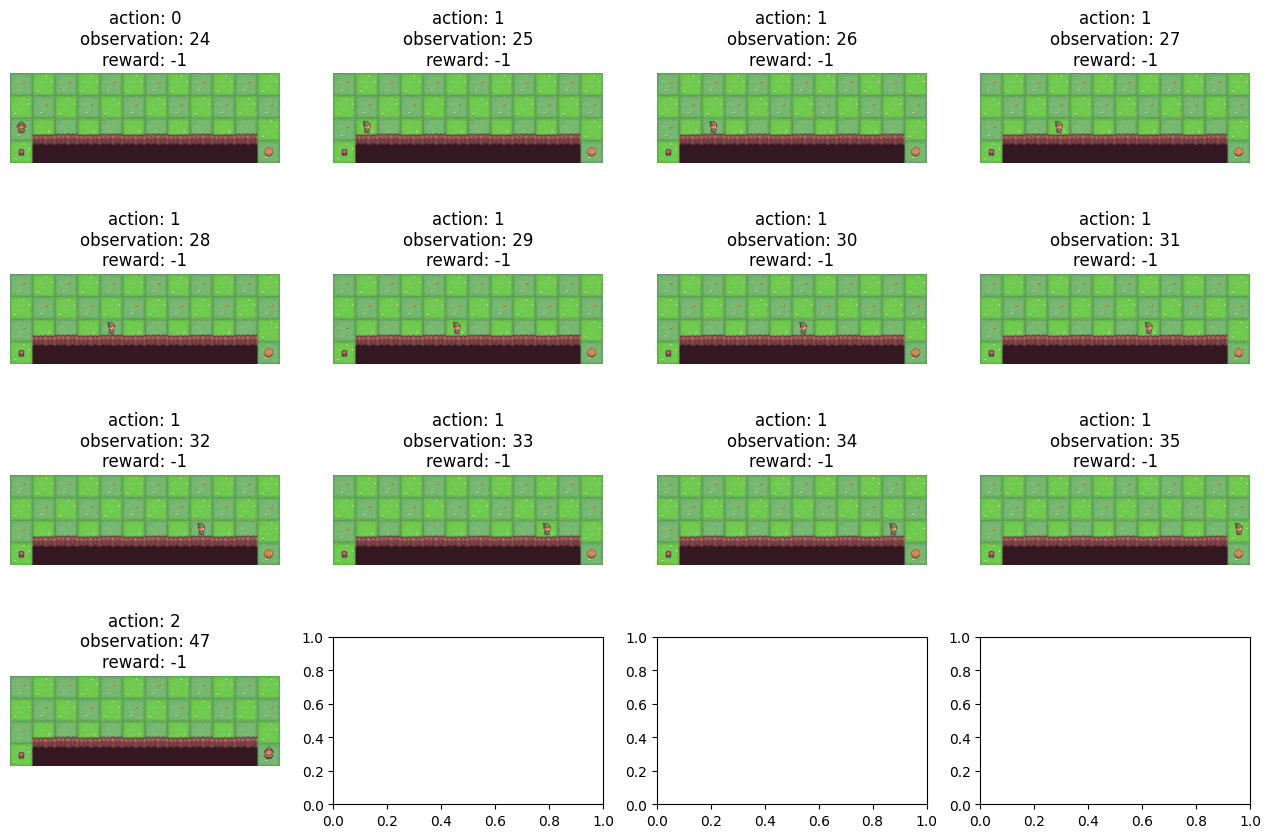

In [13]:
_, ax = plt.subplots(4, 4, figsize=(16, 10))
reward, terminated, truncated, action = 0, False, False, 0


def select_target(state: int) -> torch.Tensor:
    state = (
        F.one_hot(
            torch.tensor(state, dtype=torch.long),
            num_classes=N_OBSERVATIONS,
        )
        .type(torch.float32)
        .to(DEVICE)
        .unsqueeze(0)
    )
    with torch.no_grad():
        return target_net(state).argmax(dim=-1).type(torch.long)


observation, _ = env.reset()
for i, _ in enumerate(solution):
    action = select_target(observation).item()
    if terminated or truncated:
        break
    observation, reward, terminated, truncated, info = env.step(action)
    ax.flat[i].imshow(env.render())
    ax.flat[i].set_title(
        f"action: {action}\nobservation: {observation}\nreward: {reward}"
    )
    ax.flat[i].axis("off")
env.close()

A final question is how the training data looks.
We have the `Memoizer`, which has been updated during
the random plays and during the training.
We can make a data frame out out it.

The `Memoizer` only holds rows for single steps.
And the networks looked a step ahead into a random network,
not into the dataset.
How could this dataset prvide a solution to the game?

In [14]:
WIN_STATE = 100  # outside the board but a valid number

transitions = memoizer.sample(BATCH_SIZE)
batch = Transition(*zip(*transitions, strict=True))
pd.DataFrame(
    {
        "state": torch.cat(batch.state).max(1).indices.detach().cpu().numpy(),
        "action": torch.cat(batch.action).detach().cpu().numpy(),
        "next_state": [
            s.argmax().item() if s is not None else WIN_STATE
            for s in batch.next_state
        ],
        "reward": torch.cat(batch.reward).detach().cpu().numpy(),
    }
)

,state,action,next_state,reward
0,25,3,24,-1
1,13,2,25,-1
2,13,3,12,-1
3,27,0,15,-1
4,13,0,1,-1
...,...,...,...,...
123,18,1,19,-1
124,7,3,6,-1
125,12,1,13,-1
126,5,0,5,-1


It is easy to see how one would learn to not step onto the cliff edge.
The reward is terrible.
But how the model figured out a quick path towards the goal is a harder question.

One could explain that as the examples in the `Memoizer` get shorter and shorter
episodes the training sample point towards a short path.
While this is true out `Memoizer` holds 10_000 action samples.
We only trained on 200 episodes with up to 128 steps each,
and many were shorter than 128.
This barely scratches the number of examples the `Memoizer` holds
from the game played at random.
During training we hardly has samples from the actions taken
by the trained nets.

During the training we did manually train one of the nets indirectly from the other.
A better argument as to why the model found a short path to the goal
lies in the fact that the path pattern is in the data.
And the network did learn that pattern.
The training data is bound by the rules of the game.
It is a finite world.  During training, the network found
the best internal structure of its weights to map the rules of that world.
To compress information about that world (based on received data)
into its finite set of weights.  Indirectly the structure of the world
that generated the data got replicated in the net.